Here we want to implement FHS (filtered historical simulation) method from 'Value-at-risk models' by Peter Christoffersen, (Handbook of Financial Time Series 2009).
As part of the methodology a NGARCH(1,1) is fitted to the return series which we do now. The model for returns is:

$r_t = \sigma_tz_t, \hspace{3ex} z_t \sim G(0,1)$

Where $G$ is some distribution with zero mean and unit variance.

The dynamics for $\sigma_t$ are as follows: 

$\sigma_t^2 = \omega + \alpha(r_{t-1} - \theta \sigma_{t-1})^2 + \beta \sigma_{t-1}^2$

We prepare for the estimation of the model, the unconditional variance is given by:

$\sigma^2 = \mathbf{E}[\sigma_t^2] = \frac{\omega}{1 - \alpha (1 + \theta^2) - \beta} = \frac{\omega}{\kappa}, \hspace{3ex} \kappa = 1 - \alpha (1 + \theta^2) - \beta$

$\kappa$ can be interpreted as speed of mean reversion in variance. $\theta$ (positive) shows assymetric response of volatility to negative and positive returns.

Using definitions for $\kappa$ above we rewrite the model so that:

$\sigma_t^2 = \sigma_{t-1}^2 + \kappa(\sigma^2 - \sigma_{t-1}^2) + \alpha(r_{t-1}^2 - \sigma_{t-1}^2 - 2\theta r_{t-1} \sigma_{t-1})$

As a result we can then impose $\sigma^2$ to be sample variance and further by imposing $\kappa > 0$ we obtain stationary model. Lastly positive variance is guaranteed by forcing $\alpha > 0$. To estimate the parameters $(\kappa, \alpha, \theta)$ we perform QMLE (Quasi-Maximum-Likelihood Estimation). The QMLE is given by:

$QMLE(\kappa, \alpha, \theta) = - \frac{1}{2} \sum_{t=1}^T (\ln(\sigma_t^2) + \frac{r_t^2}{\sigma_t^2})$

We now turn to fitting above NGARCH model to our data.

In [84]:
import numpy as np
import pandas as pd;
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [85]:
path = 'datasets/DAX_daily_prices.xlsx'
data = pd.read_excel(path)
data.columns = ['Date', 'DAX']
dates = pd.to_datetime(data['Date'], format='%Y-%m-%d')
prices = np.array(data["DAX"])[::-1] # as prices were ordered from newest to oldest
losses = - np.diff(np.log(prices)) # losses are defined as negative returns

In [87]:
def sigma_sq_t_from_data(X, sigma_sq_uncon, kappa, alpha, theta):
    N = len(X)
    sigma_sq = np.zeros(N)
    sigma_sq[0] = sigma_sq_uncon
    for i in range(0, N-1):
        sigma_sq[i+1] = np.maximum(1e-6, sigma_sq[i] + kappa * (sigma_sq_uncon - sigma_sq[i]) + alpha * (X[i]**2 - sigma_sq[i] - 2*theta*X[i]*np.sqrt(sigma_sq[i])))
    return sigma_sq    

In [88]:
def neg_QMLE_GARCH11(params, x, sigma_sq_uncon):
    kappa, alpha, theta = params
    sigma_sq = sigma_sq_t_from_data(x, sigma_sq_uncon, kappa, alpha, theta)
    qmle = - 0.5 * np.sum(np.log(sigma_sq) + x**2 / sigma_sq)
    return -qmle

In [89]:
log_rets = - losses
sigma_sq_unconditional = np.var(log_rets)

In [90]:
init = [0.01, 0.2, 0.2]
bounds = [[1e-6, 1.], [1e-6, 1.], [-1., 1.]]
res = minimize(neg_QMLE_GARCH11, x0=init, args=(log_rets, sigma_sq_unconditional, ), bounds=bounds).x

In [91]:
print('Estimated parameters are\n kappa = ', res[0], '\n alpha = ', res[1], '\n theta = ', res[2])

Estimated parameters are
 kappa =  0.019315726166634697 
 alpha =  0.06269807848703111 
 theta =  0.9974480488307401


We now turn to FHS implementation to compute VaR and Expected Shortfall.

Based on FHS method we have:

$VaR_{T, 1}^{\alpha_v} = \sigma_{T+1}Quantile\{ \{z_t \}_{t=1}^T,  \alpha_v\} \hspace{3ex} z_t = \frac{r_t}{\sigma_t}$

But we can at the same time compute expected shortfall as follows:

$ES_{T, 1}^{\alpha_v} = \sigma_{T+1} \frac{1}{\alpha_v T} \sum_{t=1}^T z_t \mathbf{1}_{z_t < VaR_{T, 1}^{\alpha_v}/\sigma_{T+1}}$

Then we obtain VaR (and ES) similarly as in Historical Simulation based on window sizes. We again define a function that computes sigma_sq but now we include out of sample forecasted value (only one ahead) as we are also interested in VaR for 'tomorrow'.

In [92]:
def sigma_sq_t_from_data_one_ahead(X, sigma_sq_uncon, kappa, alpha, theta):
    N = len(X)
    sigma_sq = np.zeros(N+1)
    sigma_sq[0] = sigma_sq_uncon
    for i in range(0, N):
        sigma_sq[i+1] = np.maximum(sigma_sq[i] + kappa * (sigma_sq_uncon - sigma_sq[i]) + alpha * (X[i]**2 - sigma_sq[i] - 2*theta*X[i]*np.sqrt(sigma_sq[i])), 1e-6)
    return sigma_sq 

In [94]:
# Compute series of z_t
sigma_sq_hat = sigma_sq_t_from_data_one_ahead(log_rets, sigma_sq_unconditional, res[0], res[1], res[2])
z = log_rets / np.sqrt(sigma_sq_hat[:-1])


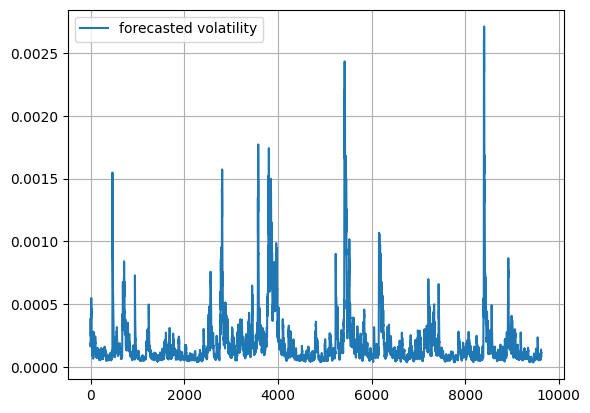

In [97]:
plt.plot(sigma_sq_hat, label='forecasted volatility');
plt.legend();
plt.grid()

In [98]:
# Compute VaR (in sample)
def var_FHS(X, z, sigma, alpha, wind):
    # create windows:
    N = len(X)
    X_wind = np.zeros(shape=(N-wind+1, wind))
    vars = []
    es = []
    for i in range(0, N-wind+1):
        X_wind[i, :] = X[i:i+wind]

    # compute values at risk and expected shortfalls.
    for i in range(N-wind+1):
        std_forecast = np.sqrt(sigma[wind+i])
        z_wind = z[i: i+wind]
        vars.append(std_forecast * np.quantile(z_wind, alpha, method='inverted_cdf')) # i.e. VaR at time t uses forecasted volatility t+1 and window of shocks up to t


        threshold = vars[i] / std_forecast
        exceedences = np.sum(z_wind < threshold)
        es.append(std_forecast * np.sum(z_wind[z_wind < threshold]) / exceedences)   
        #es.append(std_forecast * 1 / (alpha*wind) * np.sum(z_wind * np.where(z_wind < vars[i]/std_forecast, 1, 0)))
    return np.array(vars), np.array(es)

In [99]:
v, es = var_FHS(log_rets, z, sigma_sq_hat, 0.01, 252)

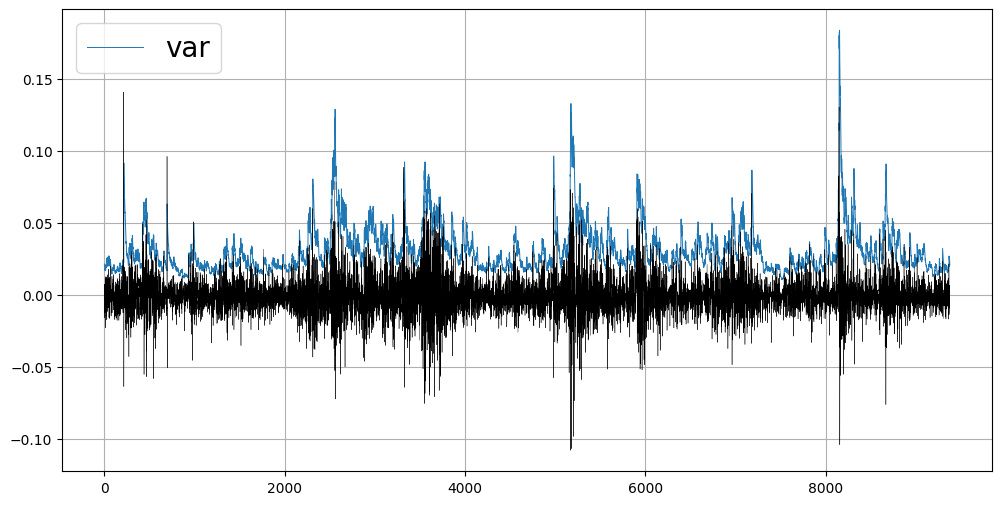

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(-v, label='var', lw=0.7)
plt.plot(-log_rets[252:], lw=0.3, color='black')
plt.legend(fontsize=20)
plt.grid()

In [101]:
np.mean(np.where(-v[:-1] < -log_rets[252:], 1, 0))

0.012052047781569966

Compared to plain Historical Simulation (see notebook 0.) we obtain closer result i.e. 1.2% compared to 1.4%. Basing on this statistic, FHS is an improvement for forecasting VaR.

Similarly the expected shortfalls are plotted below:

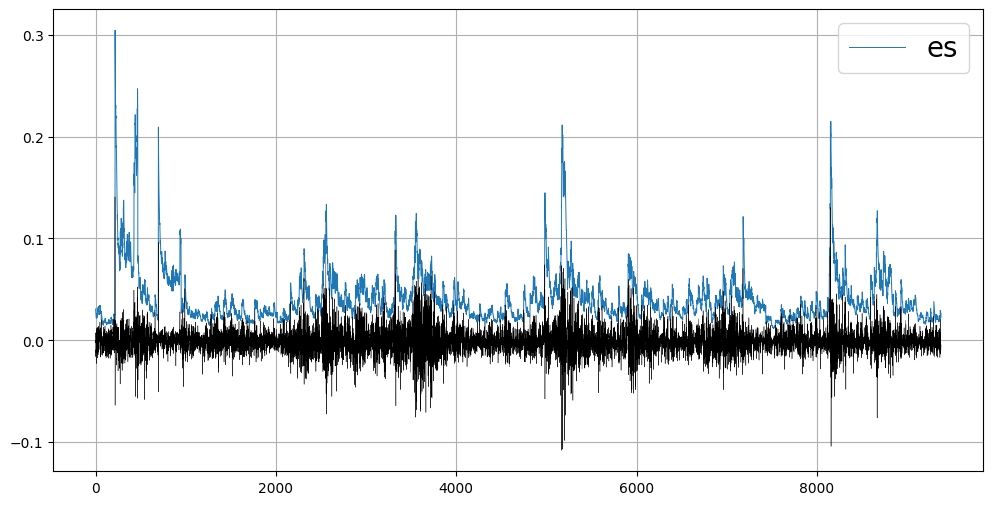

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(-es, label='es', lw=0.7)
plt.plot(-log_rets[252:], lw=0.3, color='black')
plt.legend(fontsize=20)
plt.grid()

In [103]:
np.mean(np.where(-es[:-1] < -log_rets[252:], 1, 0))

0.005972696245733789

Based on FHS method we can also build a multi-step ahead forecast. In the first step we need to obtain multi-step ahead forecast of the GARCH process. We randomly draw a shock from the window and use it as a z_t+1 -> we find return r_t+1

Draw $z_{t+1}$ from the window $\rightarrow$ Compute $r_{t+1}=\sigma_{t+1}z_{t+1} \rightarrow$ Forecast volatility $\sigma^2_{t+2} \rightarrow$ Use $z_{t+1}\sigma^2_{t+2}$ as one observation for returns at time $t+2$

We repeat this procedure M times for each time step to build up a distribution which we use to compute risk measures. We can also follow this methodology to obtain K-step forecast.

In [66]:
def multi_step_FHS(z, sigma, window, M, K, sigma_sq_uncon):
    Z_full = np.zeros(shape=(M, K-1))
    sigma_sq_pred = np.zeros(shape=(M, K))
    sigma_sq_pred[:, 0] = sigma[-1] # we will use the array from above which includes at the end forecasted volatility
    log_ret_forecast = np.zeros(shape=(M, K-1))
    # 1. Draw M times from window of z:
    for i in range(K-1):
        Z_full[:, i] = np.random.choice(z[-window:], M, replace=True)
        log_ret_forecast[:, i] = np.sqrt(sigma_sq_pred[:, i]) * Z_full[:, i]
        for m in range(M):
            sigma_sq_pred[m, i+1] = sigma_sq_t_from_data_one_ahead([log_ret_forecast[m, i]], sigma_sq_uncon, res[0], res[1], res[2])[-1]

    return Z_full, sigma_sq_pred, log_ret_forecast
        

In [67]:
K = 10
M = 1000
Z, sigma_sq_hat_multi, ret_forecast = multi_step_FHS(z, sigma_sq_hat, 252, M, K, sigma_sq_unconditional)

In [68]:
# Compute Values at Risk.
vars_K = []
for i in range(K-1):
    vars_K.append(
        np.quantile(np.sqrt(sigma_sq_hat_multi[:, i+1]) * Z[:, i], 0.01, method='inverted_cdf')
    )

Below we plot forecasted VaR and forecasted losses (negative returns) which were used to obtain it.

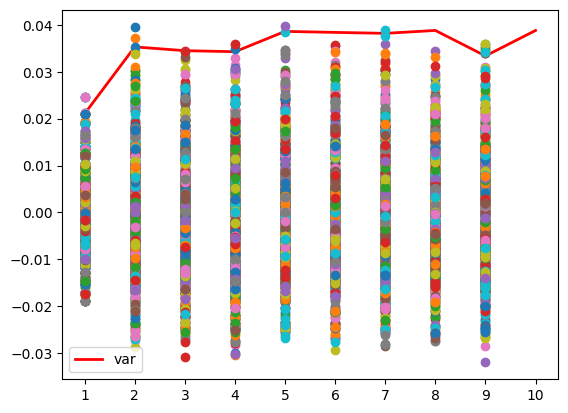

In [69]:
plt.figure()
plt.plot(np.arange(1, K+1), np.append(-v[-1], -np.array(vars_K)), color='red', lw=2, label='var')
plt.plot(np.arange(1, K), -ret_forecast.T, 'o', lw=0.1);
plt.xticks(np.arange(1, K+1))
plt.legend()

## Part 2: Wrap up

Want to define a function that is better structured and fits NGARCH for every window which is more theoretically sound.

In [104]:
def var_FHS_wrap(X, wind, alpha):
    N = len(X)
    X_wind = np.zeros(shape=(N-wind+1, wind))    
    vars = []
    es = []
    for i in range(N-wind+1):
        # Create windows.
        X_wind[i, :] = X[i: i + wind]
        # Fit GARCH:
        sigma_sq_unconditional = np.var(X_wind[i, :])
        init = [0.05, 0.2, 0.7]
        bounds = [[1e-6, 1.], [1e-6, 1.], [-1., 1.]]
        res = minimize(neg_QMLE_GARCH11, x0=init, bounds=bounds, args=(X_wind[i, :], sigma_sq_unconditional, )).x
        # Forecast volatility using fitted GARCH parameters.
        vol_forecast = sigma_sq_t_from_data_one_ahead(X_wind[i, :], sigma_sq_unconditional, res[0], res[1], res[2]) # [0] is unconditional [1] is for X[1], [2] is for X[2] and so on
        # Compute zt 
        zt = X_wind[i, :] / np.sqrt(vol_forecast[:-1])

        # Find var:
        vars.append(np.sqrt(vol_forecast[-1]) * np.quantile(zt, alpha, method='inverted_cdf'))

        # Find es:
        threshold = vars[i]
        mask = zt < threshold/np.sqrt(vol_forecast[-1])
        n_terms = np.sum(mask)
        es.append(np.sqrt(vol_forecast[-1]) * 1 / (n_terms) * np.sum(zt * mask))

    return np.array(vars), np.array(es)

In [71]:
vars, ess = var_FHS_wrap(log_rets, 252, 0.01)

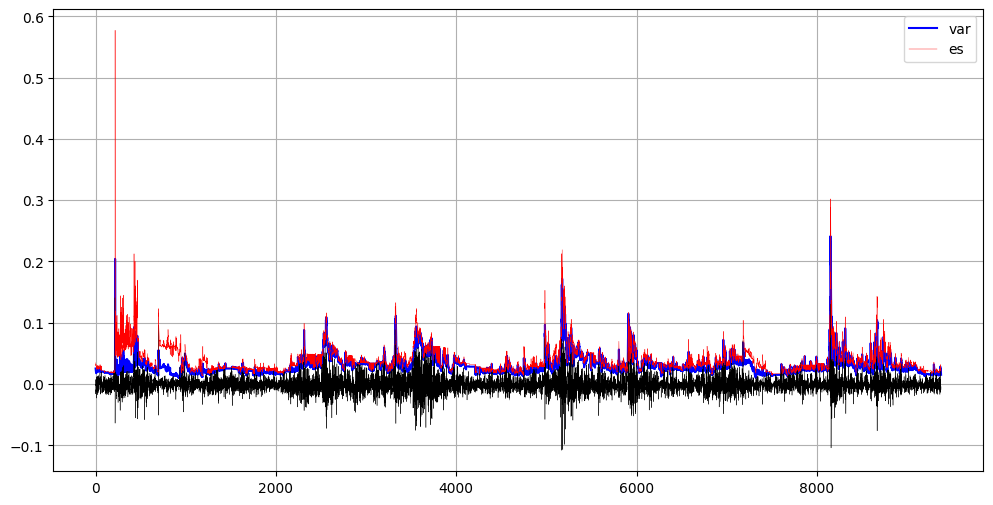

In [105]:
plt.figure(figsize=(12,6))
plt.plot(-vars, c='blue', label='var')
plt.plot(-log_rets[252:], lw = 0.3, c='black')
plt.plot(-ess, c='red', lw='0.3', label='es')
plt.grid()
plt.legend()

In [106]:
var_exceedences = np.mean(np.where(vars[:-1] > log_rets[252:], 1, 0))
es_exceedences = np.mean(np.where(ess[:-1] > log_rets[252:], 1, 0))
print('var exceedences: ', var_exceedences)
print('expected shortfall exceedences: ', es_exceedences)

var exceedences:  0.015358361774744027
expected shortfall exceedences:  0.006719283276450512


As compared to when we fitted NGACRH to whole sample the VaR result is slightly worse. As an alternative we might want to check the performance of FHS when GARCH is fitted to longer time horizons i.e. by increasing window size.